In [1]:
# Import necessary libraries and modules
import pandas as pd
import numpy as np
import seaborn as sns
import ipaddress
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# Set display options
pd.set_option('display.max_columns', None)

In [3]:
# Read csv
df = pd.read_csv('../data/interim/iot23_combined.csv', index_col=0, low_memory=False)

In [4]:
# Check dataset shape
df.shape

(1444706, 17)

In [5]:
# Check dataset
df

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,service,duration,orig_bytes,resp_bytes,conn_state,missed_bytes,history,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
0,192.168.100.111,40008,46.28.110.244,123,udp,NaN,0.004751,48.0,48.0,SF,0,Dd,1,76,1,76,Benign
1,192.168.100.102,57849,192.168.100.111,22,tcp,NaN,108.421563,2376.0,96.0,OTH,0,DAd,5,332,2,200,Benign
2,192.168.100.102,59670,192.168.100.111,22,tcp,NaN,0.001244,21.0,0.0,S0,0,SAD,3,189,0,0,Benign
3,192.168.100.102,59701,192.168.100.111,22,tcp,NaN,0.000738,21.0,0.0,S0,0,SAD,3,189,0,0,Benign
4,192.168.100.111,36199,192.168.100.1,53,udp,dns,NaN,NaN,NaN,S0,0,D,1,58,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444701,192.168.2.5,41559,219.22.220.94,22,tcp,NaN,NaN,NaN,NaN,S0,0,S,1,60,0,0,Malicious
1444702,192.168.2.5,33619,219.150.110.230,22,tcp,NaN,2.999363,0.0,0.0,S0,0,S,3,180,0,0,Malicious
1444703,192.168.2.5,48481,219.34.35.98,22,tcp,NaN,NaN,NaN,NaN,S0,0,S,1,60,0,0,Malicious
1444704,192.168.2.5,54243,219.122.26.35,22,tcp,NaN,2.997674,0.0,0.0,S0,0,S,3,180,0,0,Malicious


In [6]:
# Check dataset summary
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1444706 entries, 0 to 1444705
Data columns (total 17 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id.orig_h      1444706 non-null  object 
 1   id.orig_p      1444706 non-null  int64  
 2   id.resp_h      1444706 non-null  object 
 3   id.resp_p      1444706 non-null  int64  
 4   proto          1444706 non-null  object 
 5   service        10660 non-null    object 
 6   duration       544597 non-null   float64
 7   orig_bytes     544597 non-null   float64
 8   resp_bytes     544597 non-null   float64
 9   conn_state     1444706 non-null  object 
 10  missed_bytes   1444706 non-null  int64  
 11  history        1441055 non-null  object 
 12  orig_pkts      1444706 non-null  int64  
 13  orig_ip_bytes  1444706 non-null  int64  
 14  resp_pkts      1444706 non-null  int64  
 15  resp_ip_bytes  1444706 non-null  int64  
 16  label          1444706 non-null  object 
dtypes: float64(3)

In [7]:
# Check null values in the target attribute
df["label"].isna().sum()

0

In [8]:
# Check values distribution
df["label"].value_counts()

label
Malicious    1246872
Benign        197834
Name: count, dtype: int64

<Axes: xlabel='label', ylabel='count'>

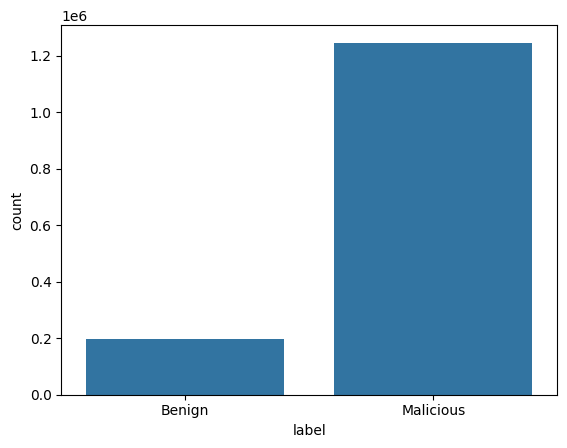

In [9]:
# Plot target attribute on a count plot
sns.countplot(data=df, x="label")

In [10]:
# Initialize encoder with default parameters
target_le = LabelEncoder()

# Fit the encoder to the target attribute
encoded_attribute = target_le.fit_transform(df["label"])

# Replace target attribute with encoded values
df["label"] = encoded_attribute

# Check mapped labels
dict(zip(target_le.classes_, target_le.transform(target_le.classes_)))

{'Benign': 0, 'Malicious': 1}

In [11]:
# Use describe() method to obtain general statistics about the numerical features
numerical_features = ["duration", "orig_bytes",	"resp_bytes", "missed_bytes", "orig_pkts",	"orig_ip_bytes", "resp_pkts", "resp_ip_bytes"]
df[numerical_features].describe()

,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,544597.000000,5.445970e+05,5.445970e+05,1.444706e+06,1.444706e+06,1.444706e+06,1.444706e+06,1.444706e+06
mean,1.833372,7.230143e+03,5.656917e+01,2.109737e-01,1.780481e+02,7.745423e+03,1.269158e-01,3.006576e+01
std,139.545955,2.792870e+06,1.587521e+04,4.366926e+01,7.230341e+04,2.849377e+06,1.548112e+01,1.017120e+04
min,0.000001,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000002,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+01,0.000000e+00,0.000000e+00
50%,0.000006,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,4.000000e+01,0.000000e+00,0.000000e+00
75%,2.998537,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,8.000000e+01,0.000000e+00,0.000000e+00
max,48976.819063,1.744830e+09,1.166102e+07,2.027200e+04,6.602735e+07,1.914793e+09,9.307000e+03,1.207699e+07


<Axes: ylabel='duration'>

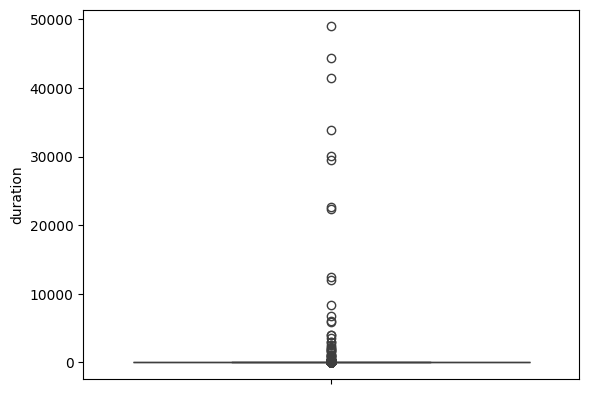

In [12]:
# Plot "duration" feature on a boxplot
sns.boxplot(data=df, y="duration")

In [13]:
# Replace outliers using IQR (Inter-quartile Range)
outliers_columns = ['duration']
for col_name in outliers_columns:
    # Calculate first and third quartiles
    q1, q3 = np.nanpercentile(df[col_name],[25,75])
    
    # Calculate the inter-quartile range
    intr_qr = q3-q1

    # Calculate lower and higher bounds
    iqr_min_val = q1-(1.5*intr_qr)
    iqr_max_val = q3+(1.5*intr_qr)
    print(f"(min,max) bounds for \"{col_name}\": ({iqr_min_val},{iqr_max_val})")
    
    # Replace values that are less than min or larger then max with np.nan
    df.loc[df[col_name] < iqr_min_val, col_name] = np.nan
    df.loc[df[col_name] > iqr_max_val, col_name] = np.nan

(min,max) bounds for "duration": (-4.497800499999999,7.4963394999999995)


In [14]:
# Reevaluate the new distribution of values
df["duration"].describe()

count    542298.000000
mean          1.016810
std           1.464098
min           0.000001
25%           0.000002
50%           0.000006
75%           2.998364
max           7.496058
Name: duration, dtype: float64

In [15]:
# A method to encode an ip address using the IPv4/IPv6 manipulation library
def encode_ipv4(ip):
    return int(ipaddress.IPv4Address(ip))

In [16]:
# Encode ip features into numerical values
df["id.orig_h"] = df["id.orig_h"].apply(encode_ipv4)
df["id.resp_h"] = df["id.resp_h"].apply(encode_ipv4)

In [17]:
# Check encoded ip addresses
ip_columns = ["id.orig_h","id.resp_h"]
for c in ip_columns:
    print(f"IP col ({c}) values: {df[c].unique()}")

IP col (id.orig_h) values: [3232261231 3232261222 3211263738 ... 3525458814 3723033929 3682566858]
IP col (id.resp_h) values: [ 773615348 3232261231 3232261121 ... 3674887997 3684069094 3682212387]


In [18]:
# Check the number of null values in each column
df.isnull().sum().sort_values(ascending=False)

service          1434046
duration          902408
resp_bytes        900109
orig_bytes        900109
history             3651
missed_bytes           0
resp_ip_bytes          0
resp_pkts              0
orig_ip_bytes          0
orig_pkts              0
id.orig_h              0
conn_state             0
id.orig_p              0
proto                  0
id.resp_p              0
id.resp_h              0
label                  0
dtype: int64

<Axes: >

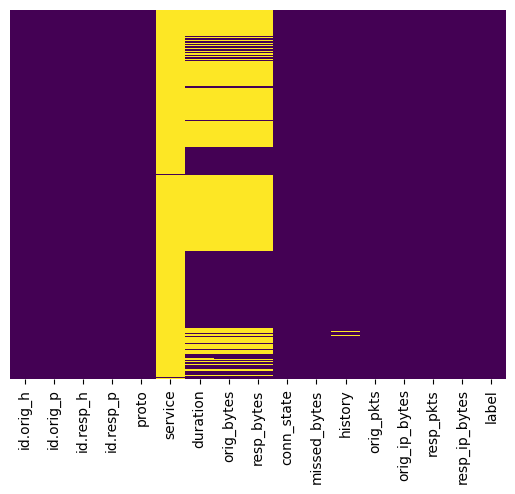

In [19]:
# Check null values using heatmap
sns.heatmap(data=df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

<Axes: xlabel='label', ylabel='count'>

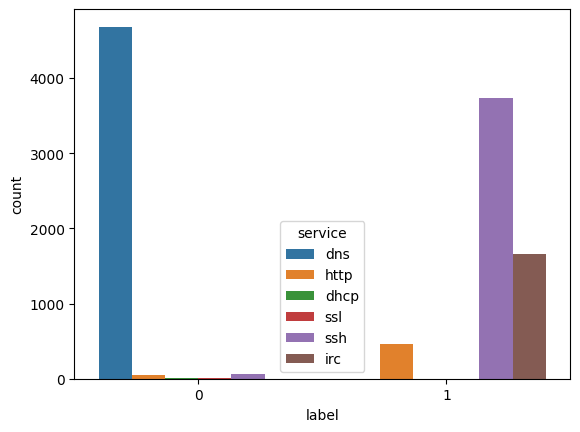

In [20]:
# Check the relationship between the "service" and the target attribute
sns.countplot(data=df, x="label", hue="service")

In [21]:
# Select specific columns to be used for the classification, here we initially select the numerical attributes with no missing values.
srv_training_columns = ["id.orig_h","id.orig_p","id.resp_h","id.resp_p","missed_bytes","orig_pkts","orig_ip_bytes","resp_pkts","resp_ip_bytes"] 

# Split the rows into two datasets containing rows with/without "service"
data_df_with_service = df[df["service"].notna()]
data_df_no_service = df[df["service"].isna()]

# Split the service dataset into dependent and independent features
srv_X = data_df_with_service[srv_training_columns]
srv_y = data_df_with_service["service"].values

# Split into train/test subsets
srv_X_train, srv_X_test, srv_y_train, srv_y_test = train_test_split(srv_X, srv_y, test_size=0.2, random_state=0)

# Create KNN estimator and fit it
srv_knn = KNeighborsClassifier(n_neighbors=3)
srv_knn.fit(srv_X_train, srv_y_train)

# Predict missing values
srv_y_pred = srv_knn.predict(srv_X_test)

# Check predictions accuracy
srv_accuracy_test = accuracy_score(srv_y_test, srv_y_pred)
print(f"Prediction accuracy for 'service' is: {srv_accuracy_test}")
print("Classification report:")
print(classification_report(srv_y_test, srv_y_pred))

Prediction accuracy for 'service' is: 0.9967166979362101
Classification report:
              precision    recall  f1-score   support

        dhcp       1.00      1.00      1.00         2
         dns       1.00      1.00      1.00       929
        http       0.99      0.97      0.98       105
         irc       0.99      1.00      1.00       313
         ssh       1.00      1.00      1.00       781
         ssl       0.00      0.00      0.00         2

    accuracy                           1.00      2132
   macro avg       0.83      0.83      0.83      2132
weighted avg       1.00      1.00      1.00      2132



In [22]:
# Predict "service" for missing values
srv_predictions = srv_knn.predict(data_df_no_service[srv_training_columns])

# Update the original data set with predicted "service" values
df.loc[df["service"].isna(), "service"] = srv_predictions

In [ ]:
# To preserve hidden correlations with other features in the dataset, we will use a KNN imputer to estimate the missing values based on relationships with other numerical features.
numerical_features = df.drop("label", axis=1).select_dtypes(include="number").columns
knn_imputer = KNNImputer()
data_df_after_imputing = knn_imputer.fit_transform(df[numerical_features])

In [ ]:
# Update original data set to fill missing values with imputed ones
df[numerical_features] = data_df_after_imputing

In [ ]:
# Confirm all missing values were successfully imputed
df.isnull().sum().sort_values(ascending=False)

In [ ]:
# Check statistics for numerical features
numerical_features = ["id.orig_h", "id.orig_p", "id.resp_h", "id.resp_p", "duration", "orig_bytes", "resp_bytes", "missed_bytes", "orig_pkts", "orig_ip_bytes",	"resp_pkts", "resp_ip_bytes"]
df[numerical_features].describe()

In [ ]:
# Initialize and apply MinMaxScaler scaler
min_max_scaler = MinMaxScaler()
df[numerical_features] = min_max_scaler.fit_transform(df[numerical_features])

In [ ]:
# Check statistics for scaled features
df[numerical_features].describe()

In [ ]:
# Look for categorical features in the dataset
df.info()

In [ ]:
# Check the number of unique values in each feature
categorical_features = ["proto","service","conn_state","history"]
for c in categorical_features:
    print(f"Column ({c}) has ({df[c].nunique()}) distinct values.")

In [ ]:
# Check values of "history" because it has too many unique values.
history_val_counts = df["history"].value_counts()
history_val_counts

In [ ]:
# Map values to their frequencies
history_freq_map = df["history"].map(history_val_counts)

# Replace low frequent values in "history" with "Other" using the corresponding frequency map
df["history"] = df["history"].mask(history_freq_map < 10, "Other")

# Check "history" values after mapping
df["history"].value_counts()

In [ ]:
# Initialize the encoder with its default parameters
ohe = OneHotEncoder()

# Fit the encoder to categorical features in the dataset
encoded_features = ohe.fit_transform(df[categorical_features])

# Create a dataframe of encoded features
encoded_features_df = pd.DataFrame(encoded_features.toarray(), columns=ohe.get_feature_names_out())

# Check the results of encoding
encoded_features_df

In [ ]:
# Merge encoded features with the dataset and drop original columns
df = pd.concat([df, encoded_features_df], axis=1).drop(categorical_features, axis=1)

In [ ]:
# Check the final version of the dataset
df

In [ ]:
# Check not null values and attribute types
df.info()

In [ ]:
# Save a new csv file (updated/changed column names)
df.to_csv('../data/processed/iot23_combined_processed.csv')